<a href="https://colab.research.google.com/github/Romanain/CoSensUs-Kit-Software/blob/main/Sensors/Training/Notebook/CoSensUs_Training_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is based on ... digikey

# Setup

In [1]:
%%capture
!pip uninstall tensorflow -y
!pip install tensorflow==2.1.1
!pip install tinymlgen

In [2]:
import tensorflow as tf
from tensorflow.keras import layers

import numpy as np
import pandas as pd
from pandas.plotting import parallel_coordinates
import random

import math
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

import json 
from tinymlgen import port
from google.colab import files

print(tf.__version__)

2.1.1


In [3]:
# Settings
val_ratio = 0.2     # Percentage of samples that should be held for validation set
test_ratio = 0.2    # Percentage of samples that should be held for test set

# Importing data


In [128]:
data_to_load = files.upload()

Saving training_data.txt to training_data.txt


In [129]:
fileName = "training_data.txt"
data_file = open(fileName).readlines()

In [130]:
item_list = []

test = json.loads(data_file[0])
for item in test:
  item_list.append(str(item))
item_list.remove('Condition')
samples_amount = len(test[item_list[0]])

item_list, samples_amount

(['AccX', 'AccY', 'AccZ', 'GyrX', 'GyrY', 'GyrZ'], 32)

In [131]:
column_names = ["Class"]
for i in item_list:
  for j in range(samples_amount):
    column_names.append(i + "_" + str(j))

In [132]:
all_data = pd.DataFrame(columns=column_names)

for txtrow in data_file:
  row = json.loads(txtrow)
  row_array = [row["Condition"]]

  for i in item_list:
    for j in range(samples_amount):
      row_array.append(float(row[i][j]))

  all_data.loc[len(all_data.index)] = row_array

In [133]:
all_data.groupby('Class').describe()

AccX_0                                                     \
          count         mean         std          min          25%   
Class                                                                
flat\n     51.0  1037.047193    1.994420  1033.016479  1035.457886   
shakin\n   58.0  1323.017624  516.614463   263.240997  1039.119995   
side\n     52.0    -0.121011    2.261544    -7.266819    -1.407444   

                                                AccX_1               ...  \
                  50%          75%          max  count         mean  ...   
Class                                                                ...   
flat\n    1036.922729  1038.875854  1040.828979   51.0  1036.922729  ...   
shakin\n  1272.640503  1717.464721  2685.848389   58.0  1317.789631  ...   
side\n      -0.064671     1.278102     6.160915   52.0     0.348490  ...   

                GyrZ_30                GyrZ_31                               \
                    75%            max   count          mean            std   
Class                                                                         
flat\n         8.544885      77.209435    51.0     -3.721985      21.092395   
shakin\n  138451.539050  251244.515600    58.0  36624.771263  144294.602047   
side\n        -6.713904      23.803673    52.0    -16.837525      32.004294   

                                                                    \
                    min           25%           50%            75%   
Class                                                                
flat\n       -44.860878    -18.157997      0.915490       8.544885   
shakin\n -248747.859400 -90924.302735  73838.195315  165562.589850   
side\n       -75.378456    -44.860878    -21.972694       8.544885   

                         
                    max  
Class                    
flat\n        46.691856  
shakin\n  251244.515600  
side\n        54.321251  

[3 rows x 1536 columns]

In [134]:
column_names = ["Class"]
for i in item_list:
  column_names.append(i + "_mean")
  column_names.append(i + "_std")
  # column_names.append(i + "_min")
  # column_names.append(i + "_max")

In [135]:
processed_data = pd.DataFrame(columns=column_names)

for txtrow in data_file:
  row = json.loads(txtrow)
  row_array = [row["Condition"]]

  for i in item_list:
    row_array.append(float(np.mean(np.absolute(row[i]))));
    row_array.append(float(np.std(np.absolute(row[i]))));
    # row_array.append(float(np.amin(row[i])));
    # row_array.append(float(np.amax(row[i])));

  processed_data.loc[len(processed_data.index)] = row_array

In [136]:
processed_data.groupby('Class').mean()

,AccX_mean,AccX_std,AccY_mean,AccY_std,AccZ_mean,AccZ_std,GyrX_mean,GyrX_std,GyrY_mean,GyrY_std,GyrZ_mean,GyrZ_std
Class,,,,,,,,,,,,
flat\n,1037.107630,2.166291,27.859288,2.152942,5.712970,3.359712,17.491696,12.557367,19.115561,13.983921,20.846768,14.975535
shakin\n,1464.571420,593.486492,663.743268,267.362915,822.517979,354.534877,101573.931206,61251.465273,94769.213639,61880.639950,130183.490638,72600.804562
side\n,1.756876,1.305742,2.600493,1.721573,996.532898,3.907364,16.822265,12.297458,20.252743,14.830978,22.001093,16.007709


#Reviewing the data

In [137]:
all_data.head()

,Class,AccX_0,AccX_1,AccX_2,AccX_3,AccX_4,AccX_5,AccX_6,AccX_7,AccX_8,...,GyrZ_22,GyrZ_23,GyrZ_24,GyrZ_25,GyrZ_26,GyrZ_27,GyrZ_28,GyrZ_29,GyrZ_30,GyrZ_31
0,flat\n,1038.875854,1038.387573,1037.411011,1038.387573,1039.364136,1036.922729,1031.063354,1039.119995,1035.702026,...,-29.602089,-6.713904,31.433067,-14.343299,-29.602089,0.915490,-14.343299,-21.972694,-37.231483,0.915490
1,flat\n,1035.457886,1037.411011,1036.434448,1035.702026,1034.481323,1034.481323,1039.608276,1034.481323,1039.364136,...,-44.860878,-6.713904,-44.860878,-21.972694,0.915490,-29.602089,-67.749062,0.915490,39.062462,8.544885
2,flat\n,1036.190308,1039.608276,1037.411011,1035.213745,1035.702026,1036.678589,1038.143433,1036.190308,1036.678589,...,31.433067,0.915490,23.803673,23.803673,-14.343299,-37.231483,-29.602089,0.915490,-21.972694,-29.602089
3,flat\n,1039.119995,1037.655151,1041.561401,1036.922729,1042.049683,1036.190308,1039.119995,1040.828979,1041.561401,...,31.433067,-6.713904,-6.713904,0.915490,8.544885,-6.713904,8.544885,-21.972694,31.433067,16.174278
4,flat\n,1035.702026,1039.364136,1040.340698,1039.608276,1038.875854,1041.073120,1036.190308,1038.387573,1037.411011,...,-6.713904,8.544885,23.803673,8.544885,0.915490,0.915490,39.062462,23.803673,77.209435,31.433067


In [138]:
def binner(data, bins):
  tmp = pd.DataFrame()
  tmp['Class'] = data['Class']

  axis = 0
  axisNames = ["AccX_", "AccY_", "AccZ_"]
  binnr = 0
  for axis in range(len(axisNames)):
    for binnr in range(bins):
      pos0 = int((64*axis)+(64/bins*(binnr+0))+1)
      pos1 = int((64*axis)+(64/bins*(binnr+1))+1)
      tmp[(axisNames[axis]+ str(binnr))] = data.iloc[:,pos0:pos1].sum(axis=1)

  return tmp

In [139]:
all_data_bin_32 = binner(all_data, 32)
all_data_bin_16 = binner(all_data, 16)
all_data_bin_8 = binner(all_data, 8)

In [140]:
all_data_bin_8

,Class,AccX_0,AccX_1,AccX_2,AccX_3,AccX_4,AccX_5,AccX_6,AccX_7,AccY_0,...,AccY_6,AccY_7,AccZ_0,AccZ_1,AccZ_2,AccZ_3,AccZ_4,AccZ_5,AccZ_6,AccZ_7
0,flat\n,8299.532225,8287.325194,8300.752929,8299.288085,229.443359,230.175781,228.222658,226.269533,-39.453030,...,-2.380368e+01,2.050782e+02,7.476797e+01,-5.493173e+01,-1.678476e+01,9.002676e+01,-6.897003e+01,-9.185821e+01,-1.834109e+02,-8.422882e+01
1,flat\n,8288.057616,8300.508790,8300.020506,8300.508789,224.804688,223.339844,225.048828,226.025391,-53.857327,...,6.774906e+01,-1.153564e+02,5.187979e+01,5.950919e+01,-8.544931e+01,2.044677e+02,4.547089e+01,-1.376346e+02,1.495331e+01,-1.147464e+02
2,flat\n,8295.137696,8300.020506,8293.916992,8292.452147,214.794922,216.503906,225.048828,224.804687,-29.443264,...,-9.154930e-01,-3.906247e+01,-6.256113e+01,2.899161e+01,-3.967294e+01,-5.493173e+01,6.072968e+01,-3.845245e+01,-9.948761e+01,-8.422882e+01
3,flat\n,8313.448241,8308.321289,8294.161133,8283.418944,214.550781,215.771484,215.527344,223.583984,-38.964749,...,5.249027e+01,1.898194e+02,-7.781992e+01,2.899161e+01,6.713858e+01,6.103424e+00,-2.444461e+02,-3.845245e+01,1.065060e+02,3.021210e+01
4,flat\n,8309.541991,8294.649414,8293.672851,8304.903320,219.189453,216.503906,219.677734,221.630859,-48.974515,...,1.516724e+02,6.774906e+01,1.373282e+01,6.103424e+00,9.002676e+01,-1.464845e+02,1.217648e+02,3.021210e+01,-3.054735e-01,2.056882e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,shakin\n,10955.782225,13941.133544,7802.949707,7468.476929,-3907.519470,-4809.863281,-4318.652344,-5293.261719,14347.021484,...,5.423498e+05,-6.598215e+05,-6.075073e+05,-1.126276e+06,-1.638353e+06,3.926834e+05,6.515191e+03,-3.358081e+05,4.550473e+05,-6.393893e+05
157,shakin\n,11032.198242,11145.479491,13325.166993,9736.788085,-5956.591797,-2333.789063,-5471.240235,-4315.966736,3270.117245,...,-1.963517e+06,9.604941e+05,1.365828e+06,-1.019464e+06,-2.528397e+05,-1.604188e+06,1.329147e+06,6.333920e+05,-8.959735e+05,2.240140e+05
158,shakin\n,15019.746825,10829.072998,10323.701416,15186.983154,-3641.162109,-5324.267578,-2348.193360,-2655.810517,3198.828182,...,1.189467e+06,-1.936585e+06,6.887268e+05,5.011581e+05,-1.807664e+06,-3.362213e+05,-1.283649e+05,1.952476e+06,1.941678e+05,7.323987e+05
159,shakin\n,10364.717529,9332.490752,16407.930055,8304.170410,-3501.269531,-2119.189453,-3123.095703,-4564.990235,1618.017624,...,-1.810174e+06,9.549399e+05,6.541580e+05,-1.791986e+06,7.993759e+05,1.159958e+05,1.812507e+06,3.584668e+05,6.423184e+05,1.678665e+06


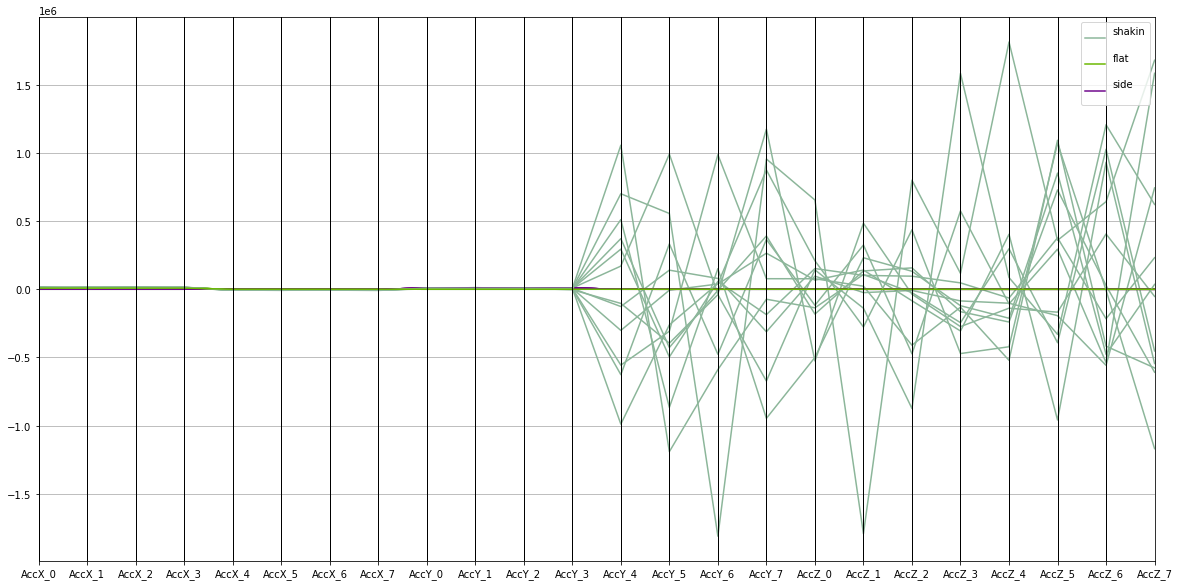

In [141]:
plt.figure(figsize=[20,10])
plt.style.context("seaborn-colorblind")
parallel_coordinates(all_data_bin_8.sample(frac=0.2, random_state=0).iloc[:,:64*3], 'Class')

No handles with labels found to put in legend.


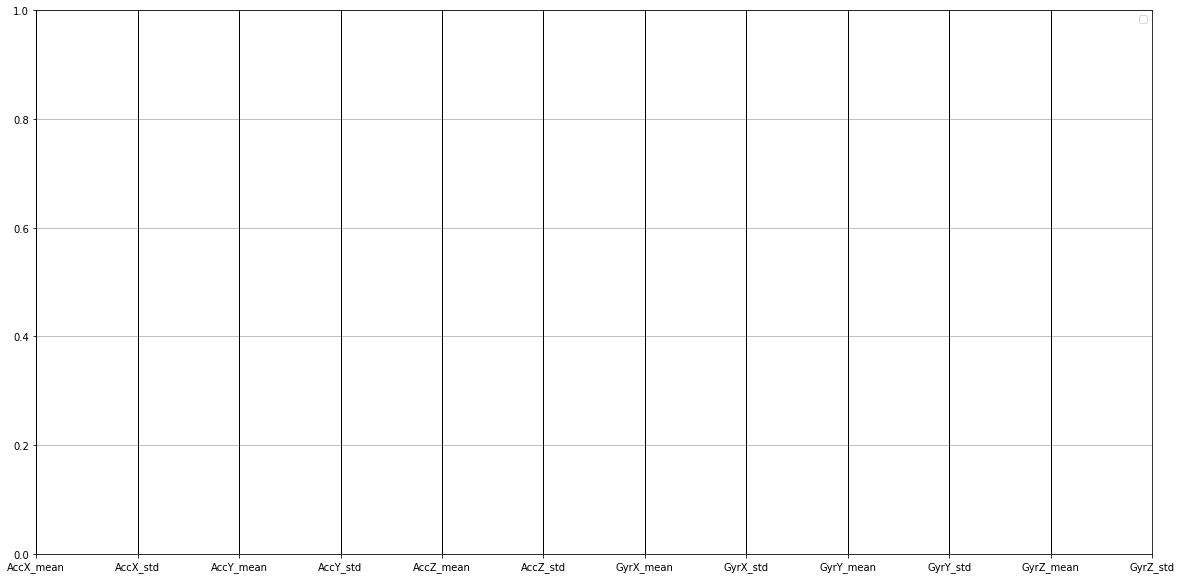

In [142]:
plt.figure(figsize=[20,10])
plt.style.context("seaborn-colorblind")
parallel_coordinates(processed_data[processed_data['Class'] == 'tappin\n'].sample(frac=0.2, random_state=0), 'Class')

# Preparing data for training

In [143]:
# Make dummies
# all_data_dataset = pd.get_dummies(all_data_.iloc[:,:64*3+1], columns=['Class'], prefix='', prefix_sep='')
# all_data_dataset = pd.get_dummies(all_data_bin_32, columns=['Class'], prefix='', prefix_sep='')
# all_data_dataset = pd.get_dummies(all_data_bin_16, columns=['Class'], prefix='', prefix_sep='')
all_data_dataset = pd.get_dummies(all_data_bin_8, columns=['Class'], prefix='', prefix_sep='')
processed_data_dataset = pd.get_dummies(processed_data, columns=['Class'], prefix='', prefix_sep='')

In [144]:
# Split all data dataset
train_dataset = all_data_dataset.sample(frac=0.8, random_state=0)
test_dataset = all_data_dataset.drop(train_dataset.index)
classes = all_data['Class'].unique()

train_dataset_features = train_dataset.copy()
train_dataset_labels = train_dataset_features[classes].copy()
train_dataset_features = train_dataset_features.drop(classes, axis=1)

test_dataset_features = test_dataset.copy()
test_dataset_labels = test_dataset_features[classes].copy()
test_dataset_features = test_dataset_features.drop(classes, axis=1)

In [145]:
# Split processed data dataset
train_prdataset = processed_data_dataset.sample(frac=0.8, random_state=0)
test_prdataset = processed_data_dataset.drop(train_dataset.index)
classes = processed_data['Class'].unique()

train_prdataset_features = train_prdataset.copy()
train_prdataset_labels = train_prdataset_features[classes].copy()
train_prdataset_features = train_prdataset_features.drop(classes, axis=1)

test_prdataset_features = test_prdataset.copy()
test_prdataset_labels = test_prdataset_features[classes].copy()
test_prdataset_features = test_prdataset_features.drop(classes, axis=1)

In [146]:
train_dataset_labels.sum()

flat\n      41
side\n      41
shakin\n    47
dtype: int64

In [147]:
test_dataset_labels.sum()

flat\n      10
side\n      11
shakin\n    11
dtype: int64

In [148]:
train_dataset_features

,AccX_0,AccX_1,AccX_2,AccX_3,AccX_4,AccX_5,AccX_6,AccX_7,AccY_0,AccY_1,...,AccY_6,AccY_7,AccZ_0,AccZ_1,AccZ_2,AccZ_3,AccZ_4,AccZ_5,AccZ_6,AccZ_7
111,11898.652771,12915.010498,14350.557251,11720.674683,-4201.953125,-4854.052734,-4413.134735,-5247.851563,4048.925781,4162.207031,...,-3.577516e+04,1.173820e+06,-5.255371e+05,4.839691e+05,-3.621826e+04,-273919.654360,-1.387180e+05,-168060.607396,4.053113e+05,-5.233796e+04
113,11022.920289,13866.670654,13203.584718,12041.963563,-4786.425782,-5104.052734,-4378.466766,-5026.171814,6034.765563,7125.097594,...,-5.890131e+05,-7.325073e+04,-1.360183e+05,1.081528e+05,-2.504882e+04,-244836.408149,2.969357e+05,-391861.265622,1.026375e+06,-4.521945e+05
144,9478.242797,15097.139280,11312.959319,9368.867432,-6145.800782,-7293.261719,-5831.835937,-4534.472655,9824.804688,5074.316406,...,5.773834e+04,-1.859674e+05,1.518005e+05,1.015915e+05,9.578552e+04,46705.637914,-6.447631e+04,377334.289110,-2.162631e+05,2.312085e+05
7,8296.358398,8277.315430,8295.625977,8295.137695,218.945313,225.048828,228.222660,233.837891,-29.199124,-59.472563,...,-8.544886e+00,1.287842e+02,1.373282e+01,-1.678476e+01,-9.307870e+01,128.173737,5.310028e+01,-68.970027,-7.934871e+00,-1.834109e+02
44,8301.241211,8285.616211,8303.194337,8293.672851,215.771484,227.490234,227.490234,234.814455,-57.031155,-33.593655,...,-9.246823e+01,6.713903e+00,-6.256113e+01,1.510619e+02,-7.781992e+01,-146.484467,-2.291873e+02,-91.858212,-2.368167e+02,-9.948761e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,-12.480259,6.806850,0.947475,-0.761509,21.191403,8.496090,11.669919,22.412106,7966.650269,7976.660034,...,2.127076e+02,9.826663e+01,-1.007081e+02,-4.730234e+01,-1.678476e+01,44.250396,-9.948761e+01,-53.711237,1.370236e+02,-1.223758e+02
154,6114.716949,12803.193969,8182.832398,12619.844726,-6061.083984,-5632.617157,-3475.146484,-2141.894531,5786.474621,1410.986401,...,1.927718e+06,-1.079858e+06,1.240546e+06,1.575758e+06,-1.185068e+06,-411134.311823,-1.095406e+06,720329.007690,1.196159e+06,-1.033524e+06
133,8918.916077,11431.123413,15068.086426,8306.123445,-4138.476563,-6069.873047,-7807.421874,-4733.691406,6065.771484,9355.078125,...,-7.205438e+05,3.618530e+04,-2.310272e+05,-7.221372e+04,4.631103e+05,447241.214850,2.442014e+05,371673.304640,-5.799029e+05,6.027295e+05
0,8299.532225,8287.325194,8300.752929,8299.288085,229.443359,230.175781,228.222658,226.269533,-39.453030,-48.974516,...,-2.380368e+01,2.050782e+02,7.476797e+01,-5.493173e+01,-1.678476e+01,90.026764,-6.897003e+01,-91.858210,-1.834109e+02,-8.422882e+01


In [149]:
processed_data_dataset

,AccX_mean,AccX_std,AccY_mean,AccY_std,AccZ_mean,AccZ_std,GyrX_mean,GyrX_std,GyrY_mean,GyrY_std,GyrZ_mean,GyrZ_std,flat\n,shakin\n,side\n
0,1037.090576,2.007154,28.565979,2.347264,6.008137,3.183027,17.881393,11.942346,18.501280,17.529977,20.160689,13.661946,1,0,0
1,1037.159241,2.098832,28.100586,2.139498,6.436147,3.271042,16.250611,12.675360,20.503994,17.667186,23.660657,19.012978,1,0,0
2,1036.922729,1.868314,27.536011,1.753566,6.262198,3.486851,16.689301,11.308357,12.922286,11.325766,17.824175,14.450788,1,0,0
3,1037.479675,2.636715,27.169800,2.119983,4.544057,2.962932,20.446779,13.053179,14.877318,12.408033,17.461774,17.601066,1,0,0
4,1037.586487,2.348255,27.406311,1.796897,5.352009,2.855011,17.862323,13.041352,18.167495,14.226620,16.431790,18.262015,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,1255.260700,408.344563,572.790525,136.282700,823.519899,660.224303,121150.931152,86008.625886,153439.135093,93316.149189,99539.994978,71614.379784,0,1,0
157,1413.738525,218.312259,564.924620,230.165605,822.769164,698.793236,195950.371957,73826.051456,153229.281405,79324.161358,104204.168153,69294.031259,0,1,0
158,1604.984512,499.315262,436.750411,235.068429,788.337709,585.425591,186126.906860,77699.560922,160527.511089,78432.206314,137525.608036,91732.675283,0,1,0
159,1387.790898,570.568475,421.590805,181.928776,738.523864,550.718339,165451.085448,79658.921218,126416.917550,89734.207681,157945.672984,89994.707001,0,1,0


In [150]:
train_dataset_labels.head()

,flat\n,side\n,shakin\n
111,0,0,1
113,0,0,1
144,0,0,1
7,1,0,0
44,1,0,0


# Create model (1)

In [151]:
# Apparently Tensorflow for ESP does not support normalizer
# Normalizer
normalizer = tf.keras.layers.experimental.preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_dataset_features))
print(normalizer.mean.numpy())

[ 6.8503691e+03  6.8173911e+03  7.0423374e+03  7.0268042e+03
 -1.8080502e+03 -1.8110159e+03 -1.8088129e+03 -1.9320055e+03
  4.9144287e+03  4.8331958e+03  4.8975396e+03  4.6787822e+03
  7.0485820e+04 -3.3944387e+04  2.8367893e+04 -3.7712598e+04
 -1.8992385e+04 -4.8371176e+02 -5.0794125e+04 -5.1380287e+01
  9.5628164e+03  1.1299150e+05  1.3702740e+04  8.4236123e+03]


In [152]:
u1 = train_dataset_features.mean()
s1 = train_dataset_features.std()

print(u1)
print(s1)

AccX_0      6850.369358
AccX_1      6817.390995
AccX_2      7042.337224
AccX_3      7026.804039
AccX_4     -1808.050205
AccX_5     -1811.015851
AccX_6     -1808.812908
AccX_7     -1932.005510
AccY_0      4914.428898
AccY_1      4833.195839
AccY_2      4897.539670
AccY_3      4678.782097
AccY_4     70485.817973
AccY_5    -33944.387667
AccY_6     28367.893306
AccY_7    -37712.598136
AccZ_0    -18992.384278
AccZ_1      -483.711751
AccZ_2    -50794.125798
AccZ_3       -51.380286
AccZ_4      9562.816347
AccZ_5    112991.503287
AccZ_6     13702.740236
AccZ_7      8423.612266
dtype: float64
AccX_0      5214.974674
AccX_1      5111.352120
AccX_2      5333.634579
AccX_3      5285.068877
AccX_4      2660.314487
AccX_5      2685.355629
AccX_6      2709.234725
AccX_7      2969.586025
AccY_0      3794.084017
AccY_1      3788.166664
AccY_2      3790.205289
AccY_3      3749.445990
AccY_4    467939.615913
AccY_5    349898.465695
AccY_6    487265.762603
AccY_7    481170.182788
AccZ_0    355576.521042
A

In [153]:
train_dataset_features_norm = pd.DataFrame()
test_dataset_features_norm = pd.DataFrame()

for i in range(train_dataset_features.shape[1]):
  train_dataset_features_norm[train_dataset_features.columns[i]] = (train_dataset_features.iloc[:,i]-u1[i])/s1[i]
  test_dataset_features_norm[test_dataset_features.columns[i]] = (test_dataset_features.iloc[:,i]-u1[i])/s1[i]

In [154]:
# Generate model
model = tf.keras.Sequential()
model.add(layers.Dropout(.1, input_shape=(train_dataset_features.shape[1],)))
model.add(layers.Dense(24, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(len(all_data['Class'].unique())))
model.build(input_shape=(train_dataset_features.shape[1],))

In [155]:
# View model
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_6 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_23 (Dense)             (None, 16)                400       
_________________________________________________________________
dense_24 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_25 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_26 (Dense)             (None, 3)                 51        
Total params: 1,595
Trainable params: 1,595
Non-trainable params: 0
____________________________________________________

# Train model (1)

In [156]:
# Add optimizer, loss function, and metrics to model and compile it
model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])
# model.compile(loss='mean_absolute_error',
#                 optimizer=tf.keras.optimizers.Adam(0.001))

In [157]:
history = model.fit(train_dataset_features.to_numpy(),
          train_dataset_labels.to_numpy(),
          epochs=300,
          batch_size=10,
          validation_data=(test_dataset_features.to_numpy(), test_dataset_labels.to_numpy()))

Train on 129 samples, validate on 32 samples
Epoch 1/300
129/129 [==============================] - 1s 5ms/sample - loss: 24725.2864 - mae: 24725.2891 - val_loss: 19647.3249 - val_mae: 19647.3262
Epoch 2/300
129/129 [==============================] - 0s 247us/sample - loss: 15426.2214 - mae: 15426.2207 - val_loss: 15033.6691 - val_mae: 15033.6699
Epoch 3/300
129/129 [==============================] - 0s 332us/sample - loss: 10191.0882 - mae: 10191.0879 - val_loss: 10109.5998 - val_mae: 10109.5996
Epoch 4/300
129/129 [==============================] - 0s 259us/sample - loss: 9984.7510 - mae: 9984.7500 - val_loss: 10515.3709 - val_mae: 10515.3711
Epoch 5/300
129/129 [==============================] - 0s 259us/sample - loss: 8336.9810 - mae: 8336.9805 - val_loss: 9357.4325 - val_mae: 9357.4326
Epoch 6/300
129/129 [==============================] - 0s 303us/sample - loss: 8087.5509 - mae: 8087.5503 - val_loss: 7691.7463 - val_mae: 7691.7461
Epoch 7/300
129/129 [============================

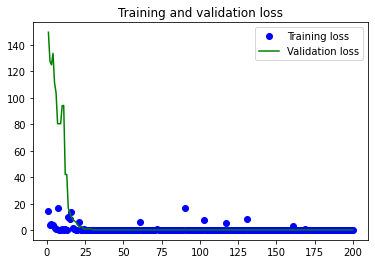

In [158]:
# Plot the training history
loss = history.history['loss'][100:]
val_loss = history.history['val_loss'][100:]

epochs = range(1, len(loss) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [159]:
test_predictions = model.predict(test_dataset_features)
rounded_predictions = np.argmax(test_predictions, axis=1)
rounded_labels = np.argmax(test_dataset_labels.to_numpy(), axis=1)

In [160]:
confusion_matrix(rounded_labels, rounded_predictions)

array([[ 0,  0, 10],
       [ 0,  0, 11],
       [ 0,  0, 11]])

# Create model (2)

In [161]:
# Normalizer
normalizer2 = tf.keras.layers.experimental.preprocessing.Normalization(axis=-1)
normalizer2.adapt(np.array(train_prdataset_features))
print(normalizer2.mean.numpy())

[  867.3591     223.46797    251.16869    100.534546   616.1269
   129.00336  37318.316    22360.816    34302.48     22374.598
 48817.727    26867.566   ]


In [162]:
u2 = train_prdataset_features.mean()
s2 = train_prdataset_features.std()

print(u2)
print(s2)

AccX_mean      867.359061
AccX_std       223.467970
AccY_mean      251.168690
AccY_std       100.534546
AccZ_mean      616.126909
AccZ_std       129.003350
GyrX_mean    37318.315188
GyrX_std     22360.817208
GyrY_mean    34302.479069
GyrY_std     22374.597125
GyrZ_mean    48817.726354
GyrZ_std     26867.565798
dtype: float64
AccX_mean      627.038871
AccX_std       305.273037
AccY_mean      320.674553
AccY_std       138.156994
AccZ_mean      432.053768
AccZ_std       191.424347
GyrX_mean    58248.581802
GyrX_std     31522.538395
GyrY_mean    53054.407620
GyrY_std     32107.725736
GyrZ_mean    66876.855839
GyrZ_std     35963.860746
dtype: float64


In [163]:
train_prdataset_features_norm = pd.DataFrame()
test_prdataset_features_norm = pd.DataFrame()

for i in range(train_prdataset_features.shape[1]):
  train_prdataset_features_norm[train_prdataset_features.columns[i]] = (train_prdataset_features.iloc[:,i]-u2[i])/s2[i]
  test_prdataset_features_norm[test_prdataset_features.columns[i]] = (test_prdataset_features.iloc[:,i]-u2[i])/s2[i]

In [164]:
train_prdataset_features_norm.head()

,AccX_mean,AccX_std,AccY_mean,AccY_std,AccZ_mean,AccZ_std,GyrX_mean,GyrX_std,GyrY_mean,GyrY_std,GyrZ_mean,GyrZ_std
111,1.152710,0.861466,1.040735,0.303892,0.169620,0.916471,1.180759,1.490137,1.932794,1.684770,0.852595,0.767390
113,1.115344,0.747038,1.097074,0.695812,0.080516,0.851359,1.241990,1.421577,0.914676,1.664879,0.600133,0.928375
144,0.872241,1.466046,1.536602,1.828246,0.568842,0.796453,0.341056,1.238783,0.235926,0.234419,1.301641,1.169460
7,0.269568,-0.723384,-0.694955,-0.708564,-1.412890,-0.652928,-0.640393,-0.708974,-0.646230,-0.696431,-0.729706,-0.746641
44,0.270529,-0.725932,-0.695003,-0.711177,-1.413314,-0.658487,-0.640355,-0.708792,-0.646227,-0.696498,-0.729543,-0.746610


In [177]:
# Generate model 2
model2 = tf.keras.Sequential()
model2.add(layers.Dropout(.1, input_shape=(train_prdataset_features.shape[1],)))
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(len(all_data['Class'].unique())))
model2.build(input_shape=(train_prdataset_features.shape[1],))

In [178]:
# View model 2
model2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_8 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 32)                416       
_________________________________________________________________
dense_31 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_32 (Dense)             (None, 3)                 51        
Total params: 995
Trainable params: 995
Non-trainable params: 0
_________________________________________________________________


# Train model (2)

In [179]:
# Add optimizer, loss function, and metrics to model and compile it

# model2.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])
model2.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

In [180]:
history2 = model2.fit(train_prdataset_features_norm.to_numpy(),
          train_prdataset_labels.to_numpy(),
          epochs=200,
          batch_size=10,
          validation_data=(test_prdataset_features_norm.to_numpy(), test_prdataset_labels.to_numpy()))

Train on 129 samples, validate on 32 samples
Epoch 1/200
129/129 [==============================] - 0s 3ms/sample - loss: 0.3886 - val_loss: 0.3062
Epoch 2/200
129/129 [==============================] - 0s 300us/sample - loss: 0.2939 - val_loss: 0.2090
Epoch 3/200
129/129 [==============================] - 0s 311us/sample - loss: 0.2145 - val_loss: 0.1361
Epoch 4/200
129/129 [==============================] - 0s 381us/sample - loss: 0.1491 - val_loss: 0.0908
Epoch 5/200
129/129 [==============================] - 0s 296us/sample - loss: 0.1263 - val_loss: 0.0673
Epoch 6/200
129/129 [==============================] - 0s 290us/sample - loss: 0.1101 - val_loss: 0.0535
Epoch 7/200
129/129 [==============================] - 0s 333us/sample - loss: 0.0998 - val_loss: 0.0508
Epoch 8/200
129/129 [==============================] - 0s 379us/sample - loss: 0.0999 - val_loss: 0.0481
Epoch 9/200
129/129 [==============================] - 0s 281us/sample - loss: 0.0915 - val_loss: 0.0496
Epoch 10/200

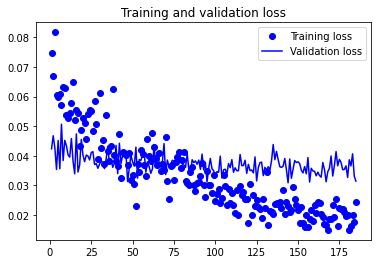

In [181]:
# Plot the training history
loss = history2.history['loss'][15:]
val_loss = history2.history['val_loss'][15:]

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [182]:
test_prpredictions = model2.predict(test_prdataset_features_norm)
rounded_prpredictions = np.argmax(test_prpredictions, axis=1)
rounded_prlabels = np.argmax(test_prdataset_labels.to_numpy(), axis=1)

In [183]:
confusion_matrix(rounded_prlabels, rounded_prpredictions)

array([[10,  0,  0],
       [ 0, 11,  0],
       [ 0,  0, 11]])

# Export model

In [172]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

In [173]:
def printArduinoArray(nameArray, convertArray):
  printstr="float " + nameArray + "[" + str(len(convertArray)) + "] = {"

  for i in range(len(convertArray)):
    printstr += str(convertArray[i])
    if (i + 1 < len(convertArray)):
      printstr += ", "

  printstr += "};\n"

  return printstr

In [174]:
def export_for_arduino(tf_lite_model_name, input_model, mean=[], std=[]):
  # Convert Keras model to a tflite model
  converter = tf.lite.TFLiteConverter.from_keras_model(input_model)
  tflite_model = converter.convert()

  open(tf_lite_model_name + '.tflite', 'wb').write(tflite_model)

  # Write header file
  if __name__ == '__main__':
      c_code = port(input_model, pretty_print=True)


  c_code += "\n\n\n" 
  if (len(mean) != 0):
    c_code += printArduinoArray("mean_array", mean) 
  if (len(std) != 0):
    c_code += printArduinoArray("std_array", std)

  textfile = open((tf_lite_model_name+"_tflite_model.h"), "w")
  a = textfile.write(c_code)
  textfile.close()

In [184]:
export_for_arduino("MVP_Sensor", model)

In [185]:
export_for_arduino("MVP_Sensor_PR", model2, u2, s2)

In [125]:
test_ar=[[-4.35,-25.45,-28.86,-15.96,5.90,22.29,29.48,21.90,34.90,34.05,26.50,21.47,6.94,14.03,-0.29,-0.46,211.62,136.21,64.58,33.40,23.25,13.50,15.17,21.06],
         [56.77,41.68,30.04,32.40,27.71,30.56,35.72,25.30,3.52,-10.04,-12.18,-2.65,4.60,5.94,20.01,25.47,230.04,163.63,98.00,89.51,85.18,86.17,81.91,77.87]]
rand_ar=[[random.randrange(0,50) for i in range(24)] for i in range(10)]  

In [126]:
model.predict(all_data_bin_8.iloc[:5,1:])


array([[-0.00117468,  0.00059114,  0.00079962,  0.00021667],
       [-0.00117468,  0.00059114,  0.00079962,  0.00021667],
       [-0.00117468,  0.00059114,  0.00079962,  0.00021667],
       [-0.00117468,  0.00059114,  0.00079962,  0.00021667],
       [-0.00117468,  0.00059114,  0.00079962,  0.00021667]],
      dtype=float32)

In [127]:
model.predict(test_ar)

array([[-0.00117468,  0.00059114,  0.00079962,  0.00021667],
       [-0.00117468,  0.00059114,  0.00079962,  0.00021667]],
      dtype=float32)

In [56]:
model.predict(rand_ar)

array([[-0.00153757,  0.00188957, -0.00124524,  0.00190649],
       [-0.00153757,  0.00188957, -0.00124524,  0.00190649],
       [-0.00153757,  0.00188957, -0.00124524,  0.00190649],
       [-0.00153757,  0.00188957, -0.00124524,  0.00190649],
       [-0.00153757,  0.00188957, -0.00124524,  0.00190649],
       [-0.00153757,  0.00188957, -0.00124524,  0.00190649],
       [-0.00153757,  0.00188957, -0.00124524,  0.00190649],
       [-0.00153757,  0.00188957, -0.00124524,  0.00190649],
       [-0.00153757,  0.00188957, -0.00124524,  0.00190649],
       [-0.00153757,  0.00188957, -0.00124524,  0.00190649]],
      dtype=float32)

In [57]:
all_data_bin_8.head()

,Class,AccX_0,AccX_1,AccX_2,AccX_3,AccX_4,AccX_5,AccX_6,AccX_7,AccY_0,...,AccY_6,AccY_7,AccZ_0,AccZ_1,AccZ_2,AccZ_3,AccZ_4,AccZ_5,AccZ_6,AccZ_7
0,flat\n,8299.532225,8287.325194,8300.752929,8299.288085,229.443359,230.175781,228.222658,226.269533,-39.453030,...,-23.803678,205.078157,74.767974,-54.931732,-16.784760,90.026764,-68.970029,-91.858210,-183.410946,-84.228817
1,flat\n,8288.057616,8300.508790,8300.020506,8300.508789,224.804688,223.339844,225.048828,226.025391,-53.857327,...,67.749060,-115.356411,51.879791,59.509186,-85.449310,204.467678,45.470888,-137.634580,14.953312,-114.746396
2,flat\n,8295.137696,8300.020506,8293.916992,8292.452147,214.794922,216.503906,225.048828,224.804687,-29.443264,...,-0.915493,-39.062466,-62.561127,28.991607,-39.672943,-54.931733,60.729682,-38.452447,-99.487608,-84.228819
3,flat\n,8313.448241,8308.321289,8294.161133,8283.418944,214.550781,215.771484,215.527344,223.583984,-38.964749,...,52.490270,189.819369,-77.819916,28.991607,67.138580,6.103424,-244.446103,-38.452447,106.506045,30.212102
4,flat\n,8309.541991,8294.649414,8293.672851,8304.903320,219.189453,216.503906,219.677734,221.630859,-48.974515,...,151.672397,67.749059,13.732819,6.103424,90.026764,-146.484467,121.764835,30.212101,-0.305474,205.688174


In [58]:
test_pr_ar = [[1.28, -0.20, -0.49, -0.08, 2.85, 12.85, 6.47, -5.69, 3.36, -1.66, 12.22, -2.03,], #2
              [-1.33, 2.01, -1.64, -1.25, 1.49, 17.31, 5.69, -2.03, 5.49, 1.16, 9.94, -2.36], #2
              [-1.81, 1.73, -0.96, -0.37, 2.13, 14.61, 4.84, -1.37, 4.87, -1.58, 12.10, -3.88], #2
              # [],
              # [],
              ]

In [59]:
model2.predict(test_pr_ar)

array([[ 0.01221474,  0.00296319,  0.97342587,  0.0075334 ],
       [-0.04857193, -0.01323044,  0.9902395 , -0.04941682],
       [-0.06930283, -0.00920452,  0.98946947, -0.07950177]],
      dtype=float32)

In [60]:
train_prdataset_features_norm

,AccX_mean,AccX_std,AccY_mean,AccY_std,AccZ_mean,AccZ_std,GyrX_mean,GyrX_std,GyrY_mean,GyrY_std,GyrZ_mean,GyrZ_std
96,-1.299725,-0.608346,-0.646561,-0.598841,0.924158,-0.565815,-0.531461,-0.581014,-0.535606,-0.574667,-0.595915,-0.609043
202,-1.283240,-0.563004,-0.642416,-0.587295,0.936351,-0.543310,-0.531328,-0.580925,-0.534721,-0.573497,-0.595767,-0.608604
169,0.398828,-0.578873,-0.558682,-0.574050,-1.234662,-0.475041,-0.530969,-0.580268,-0.535460,-0.574296,-0.595781,-0.608784
136,1.266346,1.457440,1.909193,1.203578,0.368593,1.040008,1.108809,1.745750,0.956801,1.276354,1.300919,1.618156
182,0.399041,-0.580112,-0.555372,-0.503287,-1.206901,-0.180743,-0.531046,-0.580272,-0.535303,-0.574304,-0.595775,-0.609006
...,...,...,...,...,...,...,...,...,...,...,...,...
128,0.842229,2.062939,2.224682,3.137232,0.760171,0.351981,0.167996,0.493671,0.490386,0.845387,1.752589,1.680894
34,0.396763,-0.606060,-0.562275,-0.592167,-1.264616,-0.570069,-0.531385,-0.580934,-0.535638,-0.574806,-0.595815,-0.608894
28,0.398052,-0.606524,-0.559380,-0.590674,-1.263692,-0.570633,-0.531362,-0.580928,-0.535649,-0.574746,-0.595833,-0.608908
114,1.424478,1.421302,1.559030,1.452154,0.352754,1.835932,1.103876,1.690763,1.611411,1.781283,1.091851,1.489111
